In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.backends import cudnn
from torch import nn
import torchvision  # 图片、视频处理
from torchvision.transforms import ToTensor

device = 'cuda' if torch.cuda.is_available else 'cpu'
torch.__version__, torchvision.__version__, device


('2.0.1', '0.15.2', 'cuda')

ToTensor: 
- 1、输入转为Tensor，
- 2、图片格式为 channel, height, width; 
- 3、像素取值范围规范到0/1

torch.utils.data.DataLoader, 作用：
- 乱序， shuffle 默认为 True
- 将数据采样为小批次， batch_size. batch太小会导致loss的剧烈震荡，太大则内存放不下，也会跨度过大，失去准确性；
- num_workers, 子进程设置，更多进程参与
- 设置批次处理函数 collate_fn, 用在文本等


In [2]:
train_ds = torchvision.datasets.MNIST('data', 
                                      train=True, 
                                      download=True, 
                                      transform=ToTensor())
test_ds = torchvision.datasets.MNIST('data', 
                                     train=False , 
                                     download=True, 
                                     transform=ToTensor())
# test_ds = test_ds.to(device)

In [3]:
batch_size = 2
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)  # batch_size开始为64,可能是最佳，或128
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [4]:
imgs, labels = next(iter(train_dl))   # train dataloder 可以分解出X和Ydata
imgs.shape, labels.shape   # 1: 黑白图片， 28x28的图片分辨率， 64张


(torch.Size([2, 1, 28, 28]), torch.Size([2]))

In [5]:
imgs

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [6]:
labels

tensor([6, 7])

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


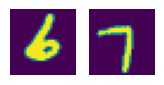

In [7]:
# labels
plt.figure(figsize=(10, 1))
for i, img in enumerate( imgs[:5] ): #取前10张图片   
    print( img.shape)       # img 被切片，降维了。
    npimg = img.numpy()         
    npimg = np.squeeze( npimg )  # 从1x28x28 变为 28x28， 1维的被 squeeze 删除
    plt.subplot(1, 10, i+1)
    plt.imshow(npimg)
    plt.axis('off')

In [8]:
labels[:5]

tensor([6, 7])

In [9]:
# f(x) = max(x, 0)
# input = torch.randint(2,[2,3,4])
input = torch.randn(5)
input

tensor([ 0.2102, -0.5019, -0.6006, -0.4131, -0.6475])

In [10]:
input, torch.relu(input)


(tensor([ 0.2102, -0.5019, -0.6006, -0.4131, -0.6475]),
 tensor([0.2102, 0.0000, 0.0000, 0.0000, 0.0000]))

In [11]:
input,torch.sigmoid( input )
input,torch.tanh( input )
input,nn.LeakyReLU( input )

(tensor([ 0.2102, -0.5019, -0.6006, -0.4131, -0.6475]),
 LeakyReLU(negative_slope=tensor([ 0.2102, -0.5019, -0.6006, -0.4131, -0.6475])))

上面是数据准备和模式测试， 
以下正式开始设计：

In [12]:
# 多层感知器模型， 添加1个隐藏层，
class Model( nn.Module ):   # 从nn类初始化
    def __init__(self):
        super().__init__()  # 初始化父类属性
        self.linear_1 = nn.Linear(28*28, 120)  # 全连接层、线性层，； 要求输入数据是1维的，所以[1, 28, 28]被压缩到1层28*28；view()
        self.linear_2 = nn.Linear(120, 84)  # 线性层， 
        self.linear_3 = nn.Linear(84, 10)  # 线性层， 
    def forward(self, input):
        x = input.view(-1, 1*28*28)
        x = torch.relu(self.linear_1(x))
        x = torch.relu(self.linear_2(x))
        logits = self.linear_3(x)            # 第3层不做激活函数， 算出在10个分量上，可能值最大的分量，就定义为分量的标签值。即哪个标签分量值最大，就是那个数字。
        return logits                         # logits: 一般指未激活前的输出2

In [13]:
model = Model().to(device)  

In [14]:
"""
- target： 0,1,2,3.。。 并不是一个独热编码的形式？
- input： logits
- output：？
"""
loss_fn = nn.CrossEntropyLoss()  
# input = torch.randn(5)
# input, np.argmax(input)

In [15]:
"""
优化： 根据计算得到的损失，调整模型参数， 降低损失的过程；
- Adam 优化器
- SGD：优化model的参数、以及lr
"""
opt = torch.optim.SGD(model.parameters(), lr=0.001)

In [16]:
"""
训练循环：计算准确率correect， 以及每个批次的平均loss
"""
def train(dl, model, loss_fn, optimizer):
    size = len( dl.dataset )    # 数据多少？
    num_batches = len(dl)       # 返回训练批次
    train_loss, correct = 0, 0 # 每个批次累计的loss之和， 正确的样本数累计
    for x, y in dl:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)     # 按照损失函数，计算损失
        optimizer.zero_grad()       # 清零后计算新的loop的梯度；
        loss.backward()             # 按照loss，反向计算梯度；
        optimizer.step()
        with torch.no_grad():
            # pred是2维，0维是batch数，1维才是0-9的logits输出；boll转换为float32，累计;item转换到python
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()  
            train_loss += loss.item()
    correct /= size
    train_loss /= num_batches      # losss是以每个批次计算，correct是以个数计算；所以分母不同；
    return correct, train_loss

In [17]:
# 测试函数: 计算准确率correect， 以及每个批次的平均loss
def test(test_dl, model, loss_fn):
    size = len( test_dl.dataset )    # 数据多少？
    num_batches = len(test_dl)       # 返回训练批次
    test_loss, correct = 0, 0 # 每个批次累计的loss之和， 正确的样本数累计
    with torch.no_grad():
        for x, y in test_dl:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)     # 按照损失函数，计算损失
            test_loss += loss.item()
            # pred是2维，0维是batch数，1维才是0-9的logits输出；boll转换为float32，累计;item转换到python
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()  
        correct /= size
        test_loss /= num_batches      # losss是以每个批次计算，correct是以个数计算；所以分母不同；
        return correct, test_loss

In [18]:
""" 
    训练 50 个 epoch， 记录每个epoch的train和test的损失、准确率。 
"""
# batch_size 非常关键：4096不准确； 64很准确。16也比较差。 ！！！
def fit(epochs, train_dl, test_dl, model, loss_fn, opt ):
    # epochs = 20
    train_loss, train_acc = [], []
    test_loss,  test_acc  = [], []

    for epoch in range( epochs ):
        epoch_acc, epoch_loss = train( train_dl, model, loss_fn, opt)
        epoch_test_acc, epoch_test_loss = test( test_dl, model, loss_fn)
        train_acc.append(epoch_acc)
        train_loss.append(epoch_loss)
        test_acc.append(epoch_test_acc)
        test_loss.append(epoch_test_loss)  # 记录、图表化后，观察是否会过拟合等问题
        
        template = ("epoch:{:2d}, train_Loss:{:.5f}, train_acc:{:.2f}, test_Loss:{:.5f}, test_acc:{:.2f}, ")
        print(template.format( epoch, epoch_loss, epoch_acc*100, epoch_test_loss, epoch_test_acc*100))
    print('Done')
    return train_loss, train_acc, test_loss, test_acc


In [ ]:
# batch_size = 16
# batch_size = 64   
# batch_size = 128
batch_size = 1024
epochs = 300
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)  # batch_size开始为64
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)
train_loss, train_acc, test_loss, test_acc = fit(epochs,train_dl, test_dl, model, loss_fn, opt)


In [ ]:
plt.plot( range(epochs), train_loss, label='train_loss')
plt.plot( range(epochs), test_loss, label='test_loss')
plt.legend()
# train_acc

In [ ]:
plt.plot( range(epochs), train_acc, label='train_acc')
plt.plot( range(epochs), test_acc, label='test_acc')
plt.legend()